# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [136]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Importing libraries

In [339]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import urllib
from geopandas import GeoDataFrame
import geopandas as gdp
from fiona.crs import from_epsg
import shapely
import statsmodels.api as sm
import pysal as ps
import seaborn as sns
from matplotlib import colors

## Downloading data

In [346]:
os.system("curl -O https://github.com/fedhere/PUI2016_fb55/raw/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp")

0

In [370]:
os.mkdir("Data") # create Data directory
os.chdir("Data")
os.mkdir("CT_Shape")
testfile = urllib.URLopener()
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv", 
                  "ACS_CT2010.csv")
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv", 
                 "CitiBike_monthly_byStation.csv")
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/Station_id.csv", 
                  "Station_id.csv")
os.chdir("CT_Shape")
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv",
                 "R10_BoroCT2010.csv")
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.cpg", 
                 "ct_shape.cpg")
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.prj", 
                 "ct_shape.prj")
os.system("curl -O https://github.com/fedhere/PUI2016_fb55/raw/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp")
os.system("curl -O https://github.com/fedhere/PUI2016_fb55/raw/master/Lab9_SRK325/Data/CT_Shape/ct_shape.dbf")
os.system("curl -O https://github.com/fedhere/PUI2016_fb55/raw/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shx")
os.chdir("/wingrdp/homedirs/hh1713/PUI2016_hh1713/HW10_hh1713")

In [366]:
os.chdir("/wingrdp/homedirs/hh1713/PUI2016_hh1713/HW10_hh1713")

In [371]:
pwd

u'/wingrdp/homedirs/hh1713/PUI2016_hh1713/HW10_hh1713'

In [320]:
testfile = urllib.URLopener()
testfile.retrieve("https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv", "ACS_CT2010.csv")

('ACS_CT2010.csv', <httplib.HTTPMessage instance at 0x7f56fdadf2d8>)

In [ ]:
newpath = r'C:\Program Files\arbitrary' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
https://github.com/fedhere/PUI2016_fb55/tree/master/Lab9_SRK325/Data

## Working with Shape File

### Loading Census Tract Shape File¶

In [372]:
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

IOError: no such file or directory: 'Data/CT_Shape/ct_shape.shp'

### Coordinate systems, projections, and transformations 

In [139]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

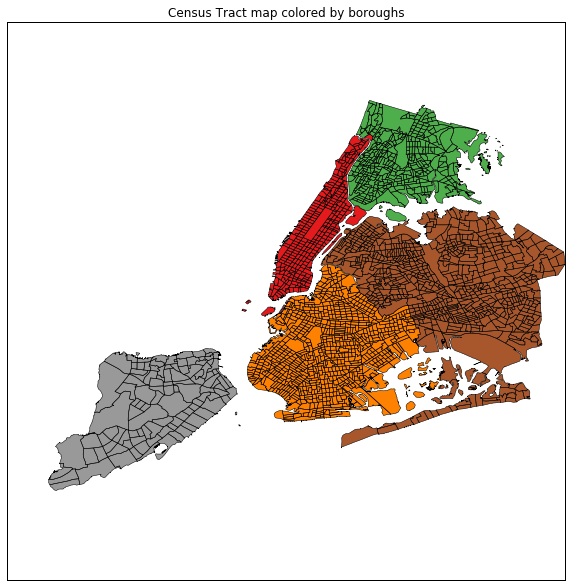

In [140]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [332]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [333]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

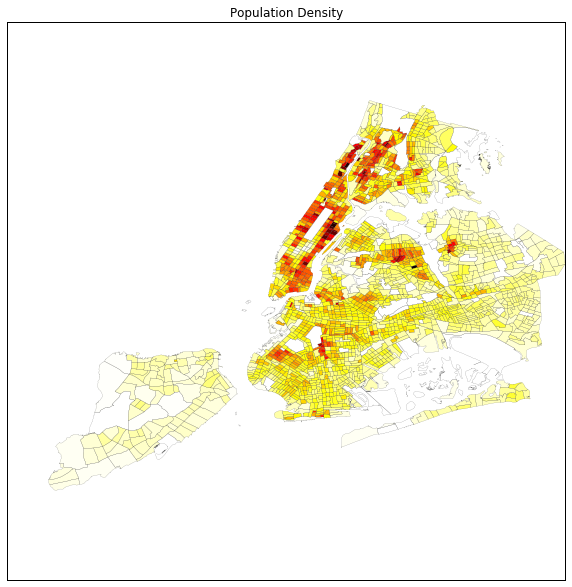

In [143]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [145]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

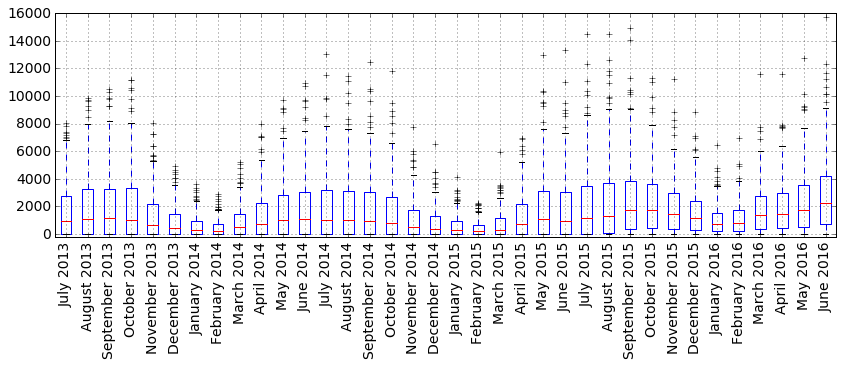

In [146]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

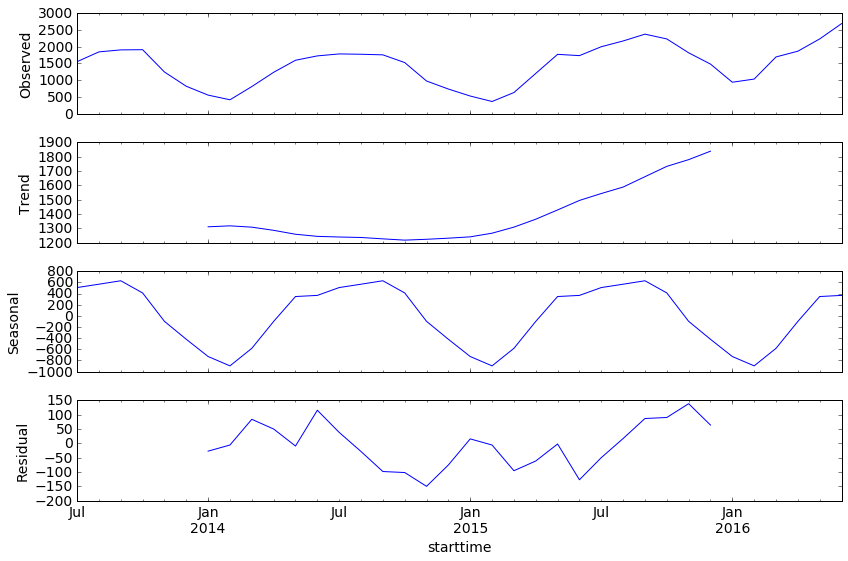

In [147]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

In [148]:
# creating masks to filter out summer and winter months
SummerMask = ((df_bike_monthly.index.month == 6) | (df_bike_monthly.index.month == 7) | 
              (df_bike_monthly.index.month == 8))
WinterMask = ((df_bike_monthly.index.month == 12) | (df_bike_monthly.index.month == 1) | 
              (df_bike_monthly.index.month == 2))

In [149]:
# creating seperate dataframes with summer and winter data
df_bike_monthly_summer = df_bike_monthly[SummerMask]
df_bike_monthly_winter = df_bike_monthly[WinterMask]

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [150]:
station_id=DataFrame.from_csv('/home/cusp/hh1713/PUIdata/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [151]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [152]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [153]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [154]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAveSummer']=df_bike_monthly_summer.sum()
station_id['MonthlyAveWinter']=df_bike_monthly_winter.sum()

In [155]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAveSummer,MonthlyAveWinter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the monthly average rides to the CT shapefile 

In [156]:
ct_shape_MonthlyAve.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,MonthlyAveSummer,MonthlyAveWinter,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,14426.0,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,12061.0,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16893.0,10509.0,1329


In [170]:
temp_summer=station_id[['MonthlyAveSummer']]
temp_summer['station_id']=station_id.index
temp_summer.index=station_id['BoroCT2010']
ct_shape_MonthlyAve_Summer=ct_shape.join(temp_summer)
ct_shape_MonthlyAve_Summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [171]:
temp_winter=station_id[['MonthlyAveWinter']]
temp_winter['station_id']=station_id.index
temp_winter.index=station_id['BoroCT2010']
ct_shape_MonthlyAve_Winter=ct_shape.join(temp_winter)
ct_shape_MonthlyAve_Winter.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [172]:
ct_shape_MonthlyAve_Summer.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,MonthlyAveSummer,station_id
BoroCT2010,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,14426.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,12061.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16893.0,1329


In [173]:
ct_shape_MonthlyAve_Winter.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,MonthlyAveWinter,station_id
BoroCT2010,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,10509.0,1329


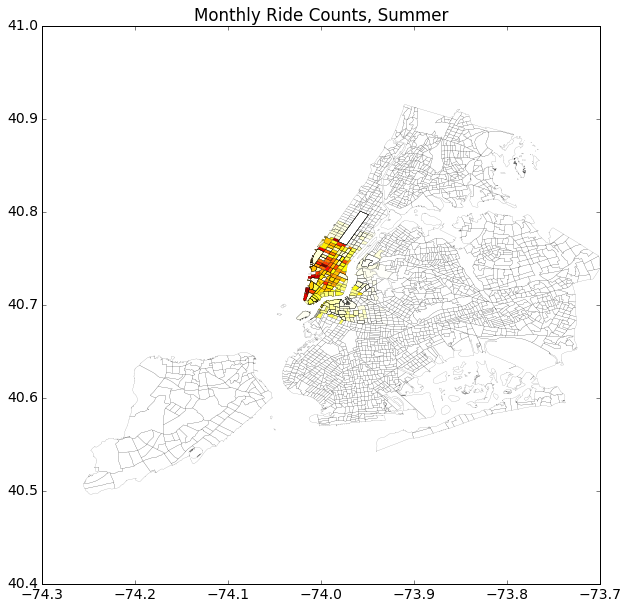

In [174]:
# plotting monthly ride count for summer
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Summer.plot(column='MonthlyAveSummer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts, Summer")

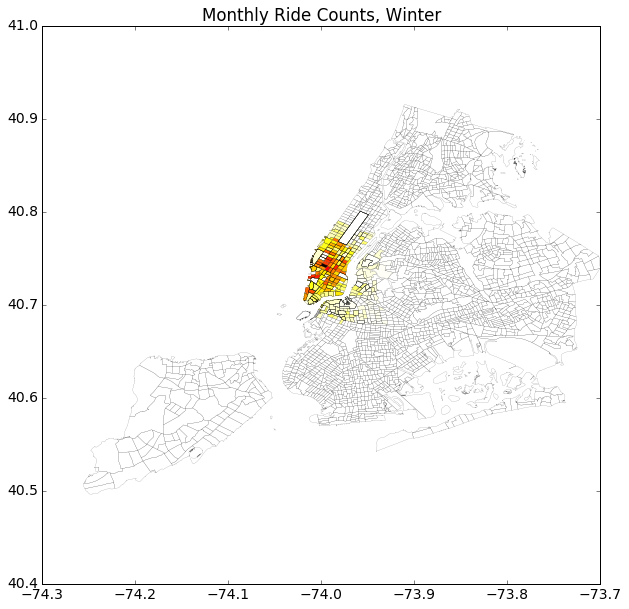

In [175]:
# plotting monthly ride count for summer
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Winter.plot(column='MonthlyAveWinter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts, Winter")

### Removing the CTs that are out of zoom boundries

In [181]:
ct_shape_MonthlyAve_Zoom.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,MonthlyAveWinter,station_id
BoroCT2010,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,10509.0,1329


In [194]:
# Removing summer CT's that are out of bounds
ct_shape_MonthlyAve_Summer_Zoom=(ct_shape_MonthlyAve_Summer[ct_shape_MonthlyAve_Summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [126]:
print "Info about summer rides \n"
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_summer.MonthlyAveSummer)

Info about summer rides 

Total number of CTs: 2166
Number of zoomed CTs: 543


In [187]:
# Removing winter CT's that are out of bounds
ct_shape_MonthlyAve_Winter_Zoom=(ct_shape_MonthlyAve_Winter[ct_shape_MonthlyAve_Winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [127]:
print "Info about winter rides \n"
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_winter.MonthlyAveWinter)

Info about winter rides 

Total number of CTs: 2166
Number of zoomed CTs: 543


The same number of census tracts have ridership info for summer and winter

In [197]:
# Combining the zoomed shapefiles for summer and winter
ct_shape_MonthlyAve_Zoom = ct_shape_MonthlyAve_Summer_Zoom
ct_shape_MonthlyAve_Zoom['MonthlyAveWinter'] = ct_shape_MonthlyAve_Winter_Zoom['MonthlyAveWinter']

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Map the monthly rides 

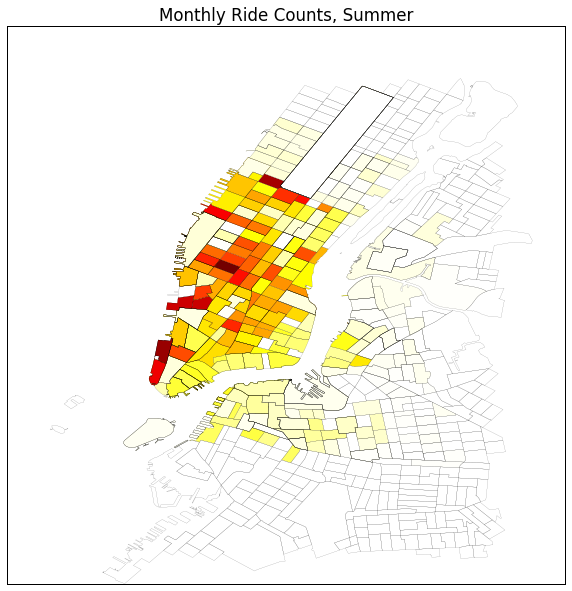

In [199]:
# mapping relevant CT's for summer rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAveSummer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts, Summer")

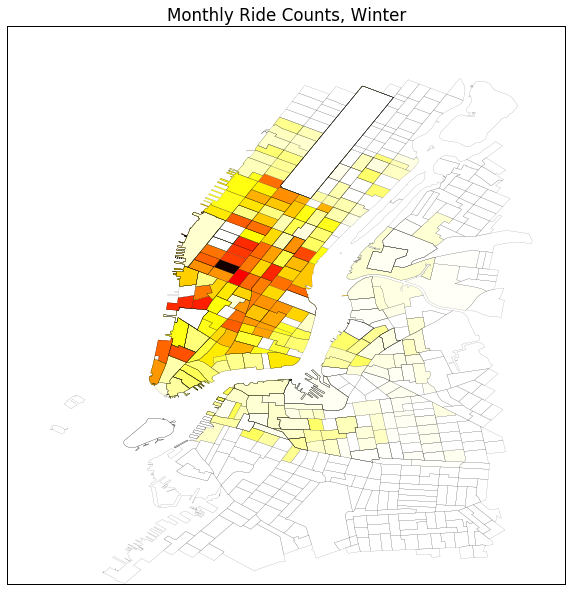

In [200]:
# mapping relevant CT's for winter rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAveWinter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts, Winter")

### Export Shapefile CTs in the CitiBike Zone

In [201]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [292]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


In [296]:
neighbor_dataframe = ps.pdio.read_files(path)

#### Neighbors of index10

In [293]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

Above we have listed the neighbors of the 10th observation. The weight of 1.0 means that the each polygon neighbors polygon nr. 10.

In [294]:
qW_CT.cardinalities[10]

9

The 10th observation has 9 neighbors.

In [302]:
# listing the 10th observation and it's neighbors
self_and_neighbors = [10]
self_and_neighbors.extend(qW_CT.neighbors[10])
neighbor_dataframe.loc[self_and_neighbors]

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,MonthlyAve,station_id,MonthlyA_1,geometry
10,1000600,1,Manhattan,E,000600,6,MN28,Lower East Side,3809,2.583418e+06,6970.634587,12098.0,1300,3978.0,<pysal.cg.shapes.Polygon object at 0x7f56ffc86...
1,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,0.0,0,0.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc63...
37,1001600,1,Manhattan,E,001600,16,MN27,Chinatown,3809,2.233320e+06,6391.788471,23243.0,1108,8315.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc0e...
38,1001600,1,Manhattan,E,001600,16,MN27,Chinatown,3809,2.233320e+06,6391.788471,20323.0,1180,9267.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc0e...
39,1001600,1,Manhattan,E,001600,16,MN27,Chinatown,3809,2.233320e+06,6391.788471,30952.0,1235,13278.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc0e...
8,1000600,1,Manhattan,E,000600,6,MN28,Lower East Side,3809,2.583418e+06,6970.634587,32316.0,1140,13560.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc63...
9,1000600,1,Manhattan,E,000600,6,MN28,Lower East Side,3809,2.583418e+06,6970.634587,13135.0,1248,6263.0,<pysal.cg.shapes.Polygon object at 0x7f56ffc86...
18,1000800,1,Manhattan,E,000800,8,MN27,Chinatown,3809,2.356750e+06,6350.461288,18701.0,1156,8874.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc72...
19,1000800,1,Manhattan,E,000800,8,MN27,Chinatown,3809,2.356750e+06,6350.461288,12351.0,1272,4208.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc72...
30,1001401,1,Manhattan,I,001401,14.01,MN28,Lower East Side,3809,1.006081e+06,5075.332419,20992.0,1157,8376.0,<pysal.cg.shapes.Polygon object at 0x7f56fdc80...


Above we see the 10th observation a long with all it's neighboring polygons

#### Matrix of Weights

In [209]:
# creating a matrix describing all of the pairwise relationships
Wmatrix, ids = qW_CT.full()

In [304]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

A matrix listing all pairwise relationships. Values are either 0 or 1 meaning an observation is either a neighbor or it is not.

#### Change the matrix to be row-standardized

In [305]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


Row standardization is a technique for adjusting the weights in a spatial weights matrix. When weights are row standardized, each weight is divided by its row sum. The row sum is the sum of weights for a features neighbors.

### Spatial Lag  
Similarity of CT neighbors can be measured by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [212]:
MonthlyRideSummer=ct_shape_MonthlyAve_Zoom.MonthlyAveSummer
MonthlyRideLagSummer=ps.lag_spatial(qW_CT, MonthlyRideSummer)

In [214]:
MonthlyRideWinter=ct_shape_MonthlyAve_Zoom.MonthlyAveWinter
MonthlyRideLagWinter=ps.lag_spatial(qW_CT, MonthlyRideWinter)

#### Create Quantiles for maping

In [221]:
MonthlyRideLagQ10Summer = ps.Quantiles(MonthlyRideLagSummer, k=10)
MonthlyRideLagQ10Summer

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [222]:
MonthlyRideLagQ10Winter = ps.Quantiles(MonthlyRideLagWinter, k=10)
MonthlyRideLagQ10Winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the monthly rides lag

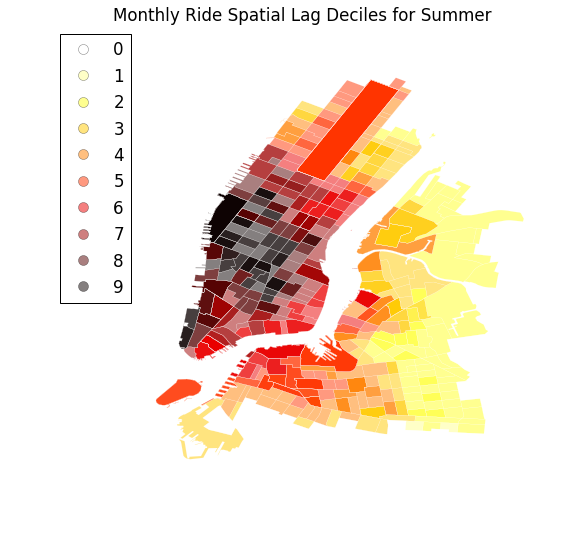

In [223]:
# summer
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles for Summer")

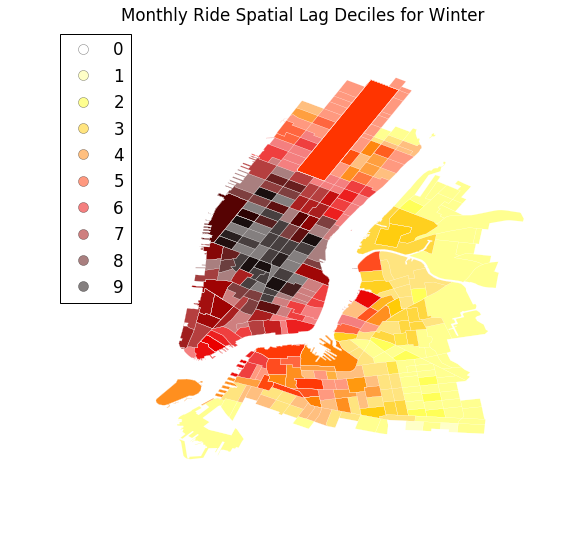

In [224]:
# winter
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles for Winter")

## Global  Spatial Autocorrelation

In [227]:
# summer
print "Summer \n"
b,a = np.polyfit(MonthlyRideSummer, MonthlyRideLagSummer, 1)
b,a 

Summer 



(0.64335490815356511, 4220.5552980795601)

In [228]:
# winter
print "Winter \n"
b,a = np.polyfit(MonthlyRideWinter, MonthlyRideLagWinter, 1)
b,a 

Winter 



(0.66023249858156818, 1600.8324238675889)

### Moran Scatterplot

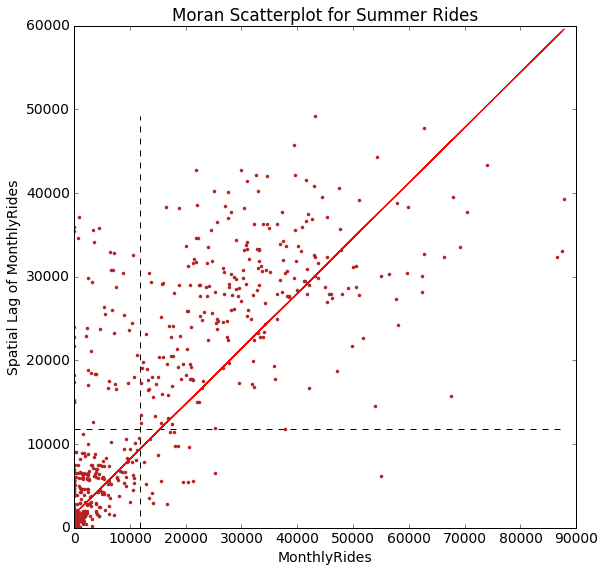

In [230]:
# summer
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRideSummer, MonthlyRideLagSummer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(), MonthlyRideLagSummer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagSummer.mean(), MonthlyRideSummer.min(), MonthlyRideSummer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSummer, a + b*MonthlyRideSummer, 'r')
plt.title('Moran Scatterplot for Summer Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

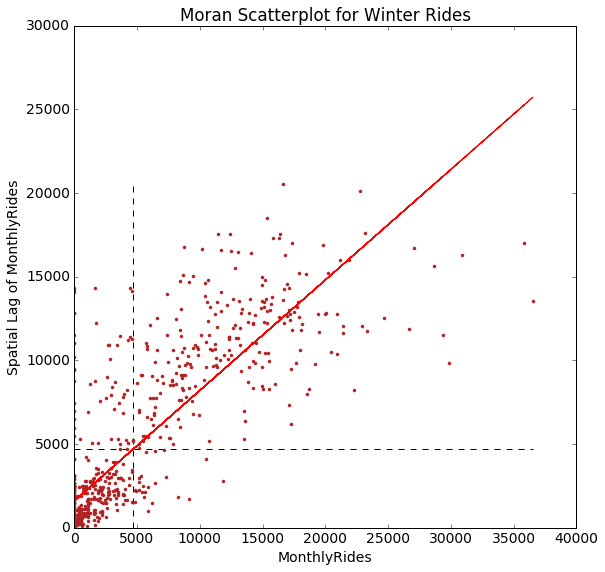

In [231]:
# winter
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRideWinter, MonthlyRideLagWinter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(), MonthlyRideLagWinter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), MonthlyRideWinter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWinter, a + b*MonthlyRideWinter, 'r')
plt.title('Moran Scatterplot for Winter Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [235]:
I_MonthlyRideSummer = ps.Moran(MonthlyRideSummer, qW_CT)
I_MonthlyRideSummer.I, I_MonthlyRideSummer.p_sim
#p.sim runs 999 simulations to test the significance

(0.64353398667011008, 0.001)

Thus, the $I$ statistic is $0.643$ for the summer data, and has a very small $p$ value. 

In [236]:
I_MonthlyRideSummer.sim[0:10]

array([-0.01763632, -0.00823088,  0.02116682,  0.01723092, -0.00041229,
        0.01359226,  0.03832978,  0.00925138, -0.0089468 ,  0.00307138])

In [237]:
I_MonthlyRideWinter = ps.Moran(MonthlyRideWinter, qW_CT)
I_MonthlyRideWinter.I, I_MonthlyRideWinter.p_sim

(0.66039156431885593, 0.001)

In [238]:
I_MonthlyRideWinter.sim[0:10]

array([  7.00723001e-03,   1.49682419e-02,   6.58907895e-04,
        -4.03092207e-05,   2.85623382e-02,  -2.28097215e-03,
         1.23735888e-02,  -1.15329724e-02,  -1.19655960e-03,
        -2.23532012e-02])

The $I$ statistic is $0.660$ for the winter data, and has a very small $p$ value. 

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [240]:
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

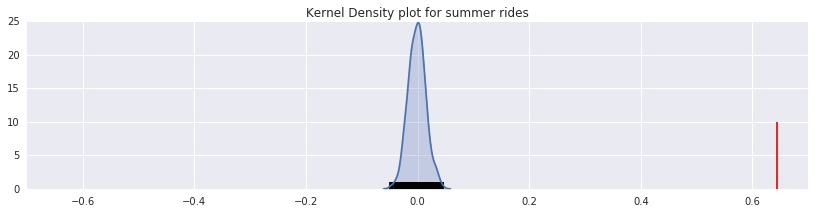

In [243]:
sns.kdeplot(I_MonthlyRideSummer.sim, shade=True)
plt.vlines(I_MonthlyRideSummer.sim, 0, 1)
plt.vlines(I_MonthlyRideSummer.I, 0, 10, 'r')
plt.title("Kernel Density plot for summer rides")
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

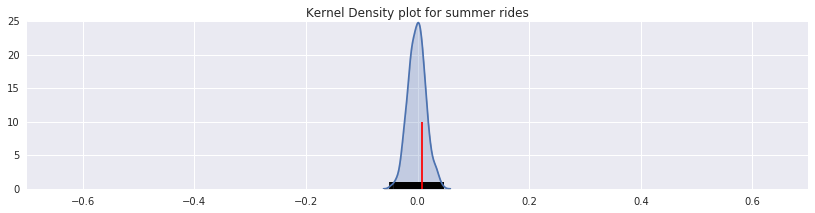

In [244]:
sns.kdeplot(I_MonthlyRideSummer.sim, shade=True)
plt.vlines(I_MonthlyRideSummer.sim, 0, 1)
plt.vlines(I_MonthlyRideSummer.EI+.01, 0, 10, 'r')
plt.title("Kernel Density plot for summer rides")
plt.xlim([-.70, .70])

(-0.7, 0.7)

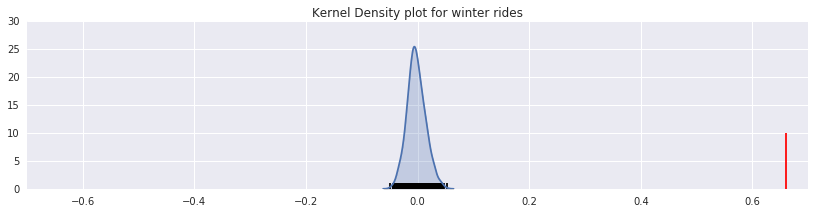

In [245]:
sns.kdeplot(I_MonthlyRideWinter.sim, shade=True)
plt.vlines(I_MonthlyRideWinter.sim, 0, 1)
plt.vlines(I_MonthlyRideWinter.I, 0, 10, 'r')
plt.title("Kernel Density plot for winter rides")
plt.xlim([-.70, .70])

(-0.7, 0.7)

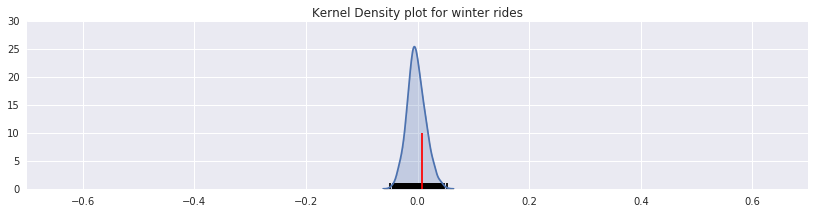

In [246]:
sns.kdeplot(I_MonthlyRideWinter.sim, shade=True)
plt.vlines(I_MonthlyRideWinter.sim, 0, 1)
plt.vlines(I_MonthlyRideWinter.EI+.01, 0, 10, 'r')
plt.title("Kernel Density plot for winter rides")
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [249]:
LMo_MonthlyRideSummer = ps.Moran_Local(MonthlyRideSummer, qW_CT,permutations=999)
print "Local Spatial Autocorrelation for summer \n"
LMo_MonthlyRideSummer.Is[0:5], LMo_MonthlyRideSummer.p_sim[0:5]

Local Spatial Autocorrelation for summer 



(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.164,  0.363,  0.373,  0.368]))

In [250]:
LMo_MonthlyRideWinter = ps.Moran_Local(MonthlyRideWinter, qW_CT,permutations=999)
print "Local Spatial Autocorrelation for winter \n"
LMo_MonthlyRideWinter.Is[0:5], LMo_MonthlyRideWinter.p_sim[0:5]

Local Spatial Autocorrelation for winter 



(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.134,  0.459,  0.499,  0.408]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [252]:
sigs_summer = MonthlyRideSummer[LMo_MonthlyRideSummer.p_sim <= .001] # finding significant
W_sigs_summer = MonthlyRideLagSummer[LMo_MonthlyRideSummer.p_sim <= .001] # finding significant
insigs_summer = MonthlyRideSummer[LMo_MonthlyRideSummer.p_sim > .001] # finding isignificant
W_insigs_summer = MonthlyRideLagSummer[LMo_MonthlyRideSummer.p_sim > .001] # finding insignificant

In [256]:
sigs_winter = MonthlyRideWinter[LMo_MonthlyRideWinter.p_sim <= .001] 
W_sigs_winter = MonthlyRideLagWinter[LMo_MonthlyRideWinter.p_sim <= .001]
insigs_winter = MonthlyRideWinter[LMo_MonthlyRideWinter.p_sim > .001]
W_insigs_winter = MonthlyRideLagWinter[LMo_MonthlyRideWinter.p_sim > .001]

### Plot Signficant LISA

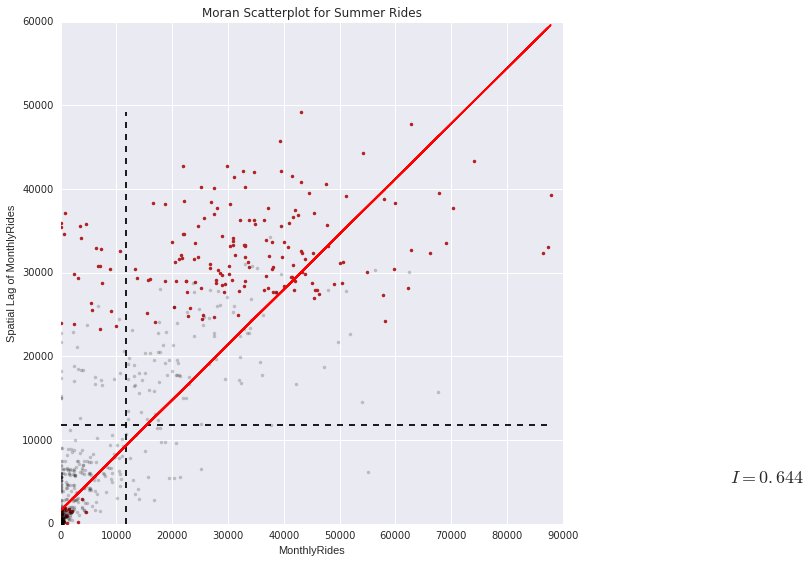

In [257]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRideSummer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(), MonthlyRideLagSummer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagSummer.mean(), MonthlyRideSummer.min(), MonthlyRideSummer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSummer, a + b*MonthlyRideSummer, 'r')
plt.title('Moran Scatterplot for Summer Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

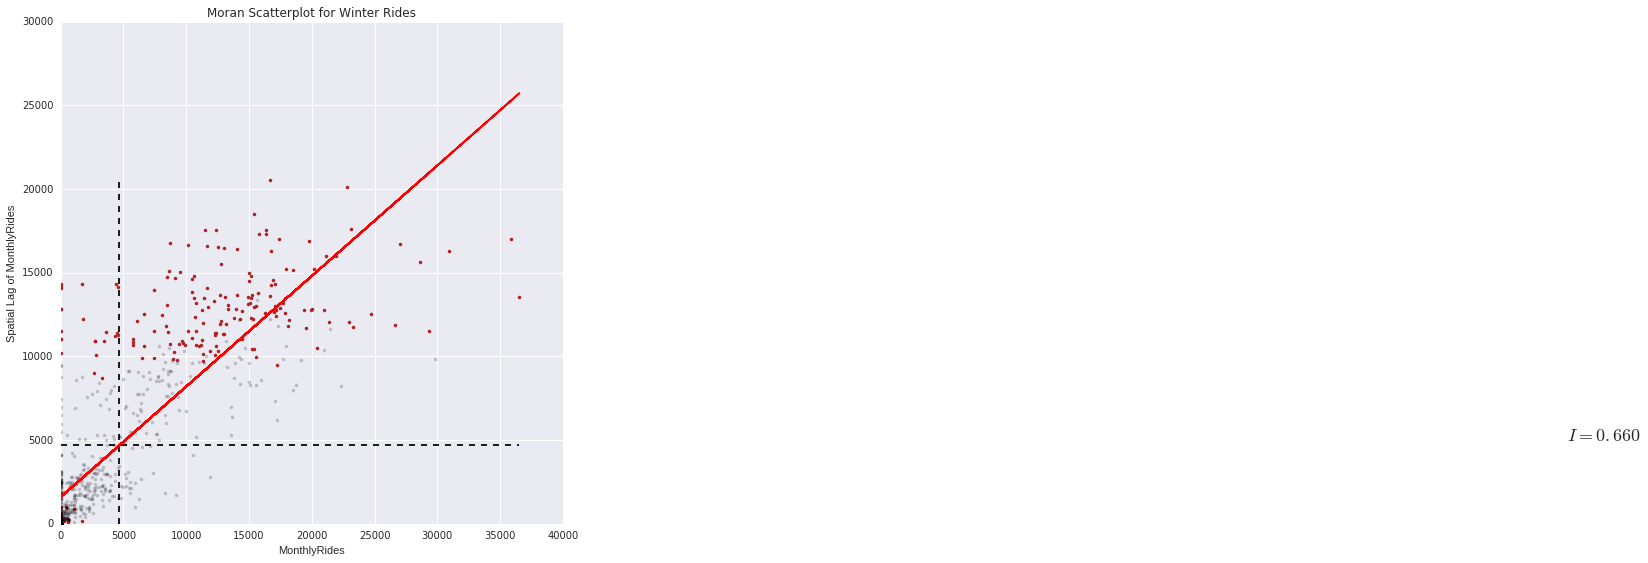

In [262]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRideWinter.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(), MonthlyRideLagWinter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), MonthlyRideWinter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWinter, a + b*MonthlyRideWinter, 'r')
plt.title('Moran Scatterplot for Winter Rides')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Hot and Cold spots 

In [264]:
sig_summer = LMo_MonthlyRideSummer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRideSummer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRideSummer.q==3 * sig_summer
print "Number of Hotspots for Summer Data:", hotspots_summer.sum()
print "Number of Coldspots for Summer Data:", coldspots_summer.sum()

Number of Hotspots for Summer Data: 190
Number of Coldspots for Summer Data: 241


In [265]:
sig_winter = LMo_MonthlyRideWinter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRideWinter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRideWinter.q==3 * sig_winter
print "Number of Hotspots for Winter Data:", hotspots_winter.sum()
print "Number of Coldspots for Winter Data:", coldspots_winter.sum()

Number of Hotspots for Winter Data: 192
Number of Coldspots for Winter Data: 217


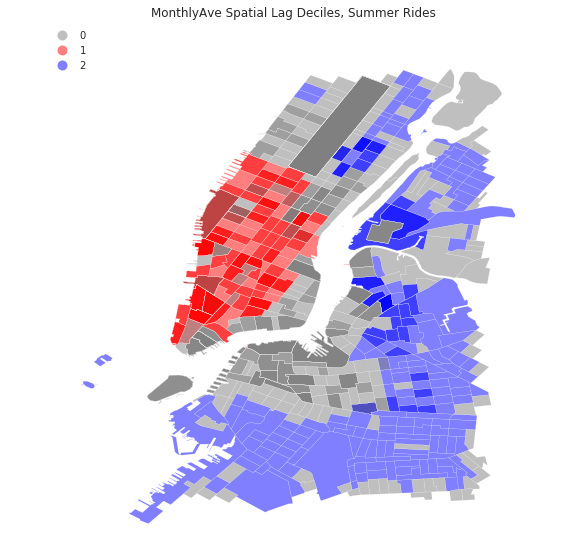

In [269]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots_summer*1 + coldspots_summer*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles, Summer Rides")

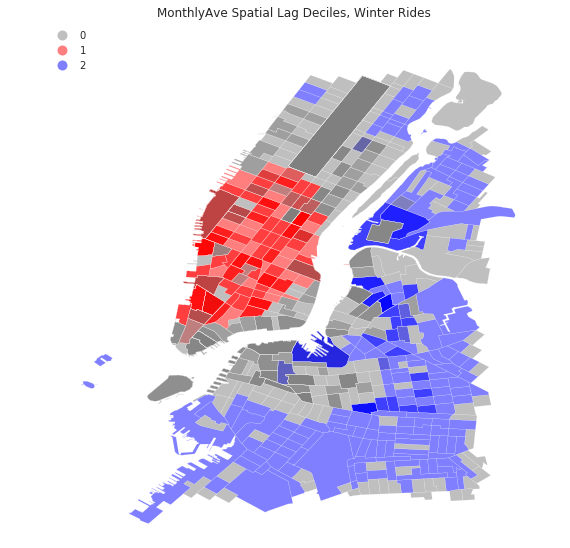

In [270]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots_winter*1 + coldspots_winter*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles, Winter Rides")